In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy import constants as const
from matplotlib.patches import Rectangle
from astropy.cosmology import Planck18_arXiv_v2
from scipy import integrate
from scipy import interpolate
from bit_tools import converters as convert
from bit_tools.mission_tools import Mission
mpl.rc('font', family='serif', serif = "cmr10", size=18)
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_UVIS2.F814W
f814w_band_response = np.genfromtxt('HST_WFC3_UVIS2.F814W.dat', usecols=range(2), delimiter=' ', invalid_raise=False)

In [3]:
f814w = interpolate.interp1d(f814w_band_response[:,0], f814w_band_response[:,1], fill_value="extrapolate")

In [11]:
bit = Mission("superbit")
r_lum = bit.get_bandpass("shape").r_lam
# Change units from nm to Angstrom
x = np.arange(300, 800, 1)
sbit_lum = interpolate.interp1d(x*10, r_lum(x), fill_value="extrapolate")

In [12]:
elliptical_template = np.genfromtxt('galaxy_spectra_kinney96/elliptical_template.ascii', usecols=range(2), invalid_raise=False)


In [13]:
starburst_all = [[], [], [], [], [], []]
for i in range(1, 7):
    starburst_all[i-1] = np.genfromtxt('galaxy_spectra_kinney96/starb%i_template.ascii' %(i), usecols=range(2), invalid_raise=False)

starburst_template = np.mean( np.array([starburst_all[0], starburst_all[1], starburst_all[2], starburst_all[3], starburst_all[4], starburst_all[5]]), axis=0 )

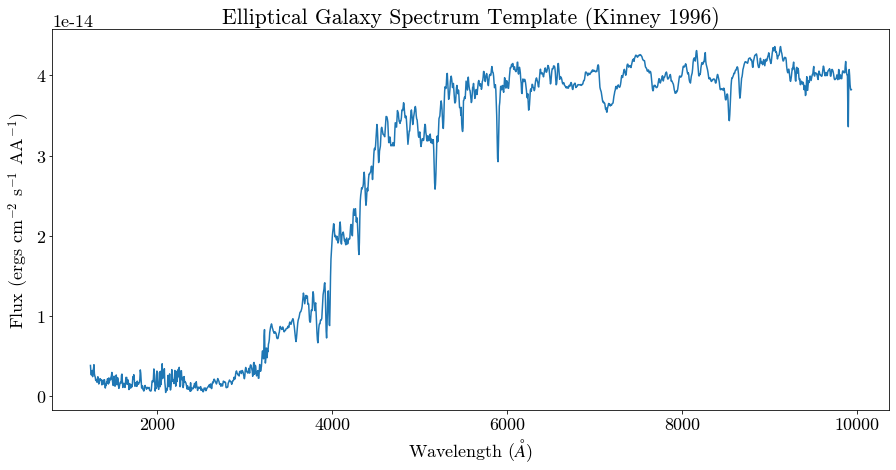

In [14]:
plt.figure(figsize=(15,7))

plt.plot(elliptical_template[:,0], elliptical_template[:,1], label='Elliptical Spectrum')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (ergs cm$^{-2}$ s$^{-1}$ AA$^{-1}$)')
plt.title('Elliptical Galaxy Spectrum Template (Kinney 1996)')

# plt.ylim(0, 6.6e-14)
plt.show()

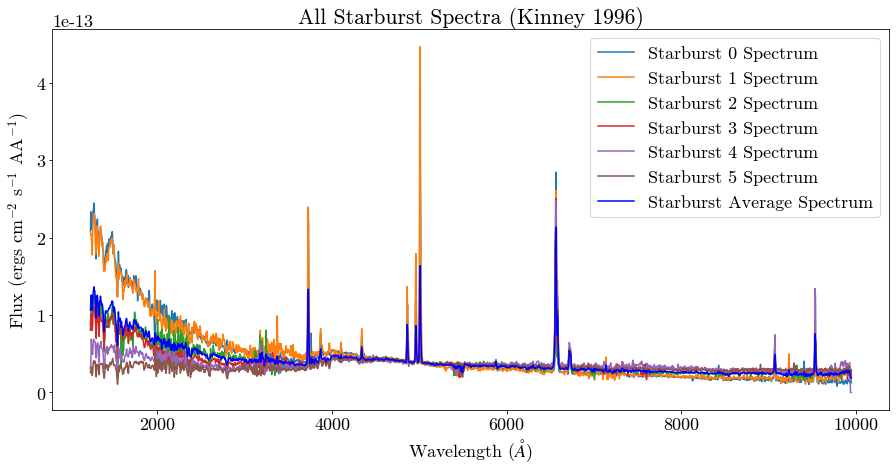

In [15]:
plt.figure(figsize=(15,7))

for i in range(6):
    plt.plot(starburst_all[i][:,0], starburst_all[i][:,1], label='Starburst %i Spectrum' %(i))

plt.plot(starburst_template[:,0], starburst_template[:,1], label='Starburst Average Spectrum', color='b')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (ergs cm$^{-2}$ s$^{-1}$ AA$^{-1}$)')
plt.legend()
plt.title('All Starburst Spectra (Kinney 1996)')

plt.show()

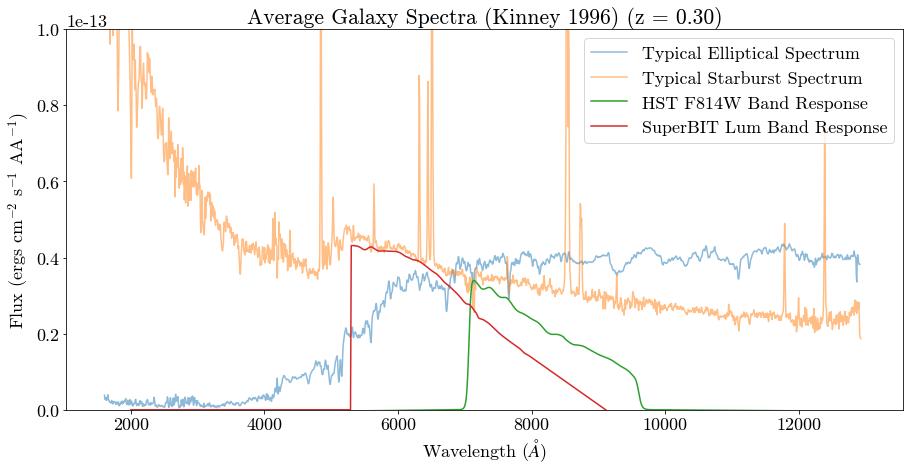

In [16]:
REDSHIFT = 0.3

plt.figure(figsize=(15,7))

ls = np.arange(2000, 13000, 1)
a1 = 0.5
a2 = 1.0

plt.plot(elliptical_template[:,0]* (1+REDSHIFT), elliptical_template[:,1], label='Typical Elliptical Spectrum', alpha=a1)
plt.plot(starburst_template[:,0]* (1+REDSHIFT), starburst_template[:,1], label='Typical Starburst Spectrum', alpha=a1)
plt.plot(ls, f814w(ls)*1.5e-13, label='HST F814W Band Response', alpha=a2)
plt.plot(ls, sbit_lum(ls)*1.5e-13, label='SuperBIT Lum Band Response', alpha=a2)


plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (ergs cm$^{-2}$ s$^{-1}$ AA$^{-1}$)')
plt.title('Average Galaxy Spectra (Kinney 1996) (z = %.2f)' %(REDSHIFT))

plt.legend()
# plt.legend(bbox_to_anchor=(0.6, 0.6))
plt.ylim(0, 1.0e-13)

# plt.savefig("spectra_overview.png")
plt.show()


https://www.astro.ljmu.ac.uk/~ikb/research/mags-fluxes/ $$ $$
https://mfouesneau.github.io/docs/pyphot/photometry.html $$ $$

For a given filter response function $R(\lambda)$ $[unitless]$ and source galaxy spectral flux density $f_\lambda (\lambda)$ $[ergs/cm^2/s/Angstrom]$, the expected spectral flux density is:
$$\langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; f_\lambda}{\int d\lambda \; \lambda \; R}$$

Then, the observed ST magnitude is
$$ m_{\text{ST}} = -2.5 \log_{10} ( \langle f_\lambda \rangle) - 21.1$$


and the observed AB magnitude is
$$ m_{\text{AB}} = -2.5 \log_{10} ( \langle f_\lambda \rangle) - -2.5 \log_{10}(\lambda_p^2/c) - 48.6$$
where $\lambda_p$ is the pivot wavelength of the filter.



Given a source ST Magnitude, we can recover
$$\langle f_\lambda \rangle =  10^{-(m+21.1)/2.5}$$

Then, for a given filter, we can use the relation
$$\langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; f_\lambda}{\int d\lambda \; \lambda \; R }$$

Thus, if we need to correct the flux density by a factor $\gamma$, we can simply scale the spectrum $f_\lambda$ by $\gamma$, such that
$$\gamma \; \langle f_\lambda \rangle = \frac{\int d\lambda \; \lambda \; R \; \gamma \; f_\lambda}{\int d\lambda \; \lambda \; R}$$

The correction to the spectral flux density is given by:
$$ \gamma = 10^{\frac{m_{\text{exp}}}{2.5} - \frac{m_{\text{obs}}}{2.5}}.$$

In [17]:
# Test units
e_wavelength = elliptical_template[:,0]  * u.AA # Angstrom
e_flux = elliptical_template[:,1] * u.erg / (u.AA * u.s * u.cm**2) # erg s^-1 cm^-2 Angstrom^-1
r = f814w(e_wavelength) # unitless

non0_indices = np.nonzero(e_flux)

r = r[non0_indices]
lam = e_wavelength[non0_indices]
f_lam = e_flux[non0_indices]
 
f1 = np.trapz(y=f_lam * r * lam, x=lam)
f2 = np.trapz(y=r * lam, x=lam) 

f_exp = f1/f2 # erg s^-1 cm^-2 AA^-1
print("f_lambda = %s" %f_exp)

mag = -2.5 * np.log10(f_exp.value) - 21.1
print("ST Magnitude = %.2f" %mag)

f_lambda = 4.061161963533001e-14 erg / (Angstrom cm2 s)
ST Magnitude = 12.38


In [18]:
# Get the required corrective factor for the spectral flux density
def get_correction(m_exp, m_obs):
    return np.power(10, (m_exp/2.5)-(m_obs/2.5))

In [20]:
# Get mag from Response Function, Spectrum, Lambda Range, and Scaling Correction to Spectrum
def get_stmag(r, f_lam, lam, correction=1.0):
    """
    Returns the observed ST mag for a given filter and source spectrum

    Args:
        r: Filter Response Function, [unitless]
        f_lam: Source Spectral Flux Density, [ergs/s/cm^2/Angstrom]
        lam: Wavelength range, [Angstrom]
        correction: constant factor to scale f_lam depending on the source

    Returns:
        ST Magnitude
    """
    f_lam = f_lam * correction
    f1 = np.trapz(y=f_lam * r * lam, x=lam)
    f2 = np.trapz(y=r * lam, x=lam) 

    f_exp = f1/f2 # erg s^-1 cm^-2 AA^-1

    mag = -2.5 * np.log10(f_exp) - 21.1
    return mag

In [21]:
# Get SuperBIT magitudes from Observed Mag
def stmag_conversion(mag_obs, z, src_band, target_band, e_template, starb_template):
    """
    Converts ST Mag from one filter to another, assuming both Elliptical and Starburst 
    spectra for the source

    Parameters
    ----------
    mag_obs : float
        ST Mag observed by Source Band, [unitless]

    z : float
        Redshift of source galaxy

    src_band : scipy.interpolate.interpolate.interp1d
        Band we are converting from

    target_band : scipy.interpolate.interpolate.interp1d
        Band we are converting to

    e_template : numpy array
        Template spectral energy density array for an Elliptical Galaxy, organized as follows:
        e_template[:,0] = wavelengths, [Angstrom]
        e_template[:,1] = flux density, [erg/s/cm^2/Angstrom]

    starb_template : numpy array
        Template spectral energy density array for a Starburst Galaxy, organized as follows:
        starb_template[:,0] = wavelengths, [Angstrom]
        starb_template[:,1] = flux density, [erg/s/cm^2/Angstrom]

    Returns:
        ST Magnitude
    """

    # Elliptical Spectrum Template with redshift
    e_wavelength = e_template[:,0] * (1+z)
    e_flux = e_template[:,1]

    # Starburst Spectrum Template with redshift
    starb_wavelength = starb_template[:,0] * (1+z)
    starb_flux = starb_template[:,1]

    # Get Modified Elliptical Spectrum for the given source
    non0_indices = np.nonzero(src_band(e_wavelength))
    lam = e_wavelength[non0_indices]
    f_lam = e_flux[non0_indices]
    r = src_band(lam)
    e_mag_exp = get_stmag(r, f_lam, lam)
    e_corr = get_correction(e_mag_exp, mag_obs)
    src_e_mag = get_stmag(r, f_lam, lam, correction=e_corr)



    # Get Modified Starburst Spectrum
    non0_indices = np.nonzero(src_band(starb_wavelength))
    lam = starb_wavelength[non0_indices]
    f_lam = starb_flux[non0_indices]
    r = src_band(lam)
    starb_mag_exp = get_stmag(r, f_lam, lam)
    starb_corr = get_correction(starb_mag_exp, mag_obs)
    src_starb_mag = get_stmag(r, f_lam, lam, correction=starb_corr)


    

    # Get Elliptical mag for Target Band
    non0_indices = np.nonzero(target_band(e_wavelength))
    lam = e_wavelength[non0_indices]
    f_lam = e_flux[non0_indices]
    r = target_band(e_wavelength)[non0_indices] #unitless
    target_e_mag = get_stmag(r, f_lam, lam, correction=e_corr)

    # Get Starburst mag for Target Band
    non0_indices = np.nonzero(target_band(starb_wavelength))
    lam = starb_wavelength[non0_indices]
    f_lam = starb_flux[non0_indices] #erg s^-1 cm^-2
    r = target_band(starb_wavelength)[non0_indices] #unitless
    target_starb_mag = get_stmag(r, f_lam, lam, correction=starb_corr)


    return target_e_mag, target_starb_mag, src_e_mag, src_starb_mag



In [22]:
# Test the mag conversion
mag_obs = 23.2
z = 0.55

super_e_mag, super_starb_mag, hst_e_mag, hst_starb_mag = stmag_conversion(mag_obs, z, f814w, sbit_lum, elliptical_template, starburst_template)


print("Original HST Mag: %.2f" %mag_obs)
print("")
print("HST Refitted Elliptical Mag: %.2f" %hst_e_mag)
print("HST Refitted Starburst Mag: %.2f" %hst_starb_mag)
print("")
print("SuperBIT Elliptical Mag: %.2f" %super_e_mag)
print("SuperBIT Starburst Mag: %.2f" %super_starb_mag)

Original HST Mag: 23.20

HST Refitted Elliptical Mag: 23.20
HST Refitted Starburst Mag: 23.20

SuperBIT Elliptical Mag: 22.97
SuperBIT Starburst Mag: 23.84
